In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_image = np.load("/content/gdrive/MyDrive/CS329E Cloud Forecasting/Data_jrse/ForecastData/image_log_pred_train2.npy")
# data_date = np.load("/content/gdrive/MyDrive/CS329E Cloud Forecasting/Data_jrse/ForecastData/datetime_log_trainval.npy", allow_pickle=True)
data_pv = np.load("/content/gdrive/MyDrive/CS329E Cloud Forecasting/Data_jrse/ForecastData/pv_log_train2.npy", allow_pickle=True)
# data_image = np.load("/content/gdrive/MyDrive/CS329E Cloud Forecasting/Data_jrse/images_test.npy")
# data_date = np.load("/content/gdrive/MyDrive/CS329E Cloud Forecasting/Data_jrse/ForecastData/datetime_log_trainval.npy", allow_pickle=True)
# data_pv = np.load("/content/gdrive/MyDrive/CS329E Cloud Forecasting/Data_jrse/pv_log_test.npy", allow_pickle=True)
data_pred_pv = np.load("/content/gdrive/MyDrive/CS329E Cloud Forecasting/Data_jrse/ForecastData/pv_pred_train2.npy", allow_pickle=True)

In [ ]:
# data_image = data_image.reshape(data_image.shape[0]*data_image.shape[1],64,64,3)
# data_pv = data_pv.reshape(data_pv.shape[0] * data_pv.shape[1])
print(data_image.shape)
data_image = data_image[:, 15, :, :, :]
print(data_image.shape)
# data_pv = data_pv.reshape(data_pv.shape[0] * data_pv.shape[1])

(13373, 16, 64, 64, 3)
(13373, 64, 64, 3)


In [ ]:
norm = np.linalg.norm(data_image)
data_image = data_image/norm

In [ ]:
print(data_pred_pv.shape)

(13373,)


In [ ]:
def scale(array):
  return np.interp(array, (array.min(), array.max()), (0, +30))

In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
data_image = data_image.reshape(data_image.shape[0], 3, 64, 64)
# change data size back to what it what
train_x = torch.Tensor(data_image[:5000])  # as torch.float32
train_y = torch.Tensor(data_pred_pv[:5000])
test_x = torch.Tensor(data_image[5000:6000])  # as torch.float32
test_y = torch.Tensor(data_pred_pv[5000:6000])

print(len(train_y))
print(len(test_y))
#train_x = torch.Tensor(data_image[10000:])  # as torch.float32
#train_y = torch.Tensor(data_pred_pv[10000:])
#test_x = torch.Tensor(data_image[:10000])  # as torch.float32
#test_y = torch.Tensor(data_pred_pv[:10000])

# train_x = torch.Tensor(data_image)  # as torch.float32
# train_y = torch.Tensor(data_pred_pv)
# # test_x = torch.Tensor(data_image[200:])  # as torch.float32
# # test_y = torch.Tensor(data_pred_pv[200:])

# my_dataset = TensorDataset(train_x, train_y)
# data_loader = torch.utils.data.DataLoader(my_dataset, batch_size=1, num_workers=0,shuffle=True)
# # print(len(data_loader))
# train_dataset, test_dataset = torch.utils.data.random_split(data_loader.dataset, [200, 61])
# print(type(loader_train))
# loader_train = DataLoader(train_dataset, shuffle=True)
# loader_test = DataLoader(test_dataset, shuffle=True)
my_dataset1 = TensorDataset(train_x, train_y) # create your datset
loader_train = DataLoader(my_dataset1) # create your dataloader


my_dataset2 = TensorDataset(test_x, test_y) # create your datset
loader_val = DataLoader(my_dataset2) # create your dataloader

print(type(loader_train))

5000
1000
<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def check_accuracy_part34(loader, model):
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    predictions = np.zeros(len(test_y),)
    i = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            scores = model(x)
            # print(scores)
            # _, preds = scores.max(1)
            # print(preds.numpy())
            predictions[i] = scores
            # print(predictions)
            # i += 1
            # num_correct += (preds == y).sum()
            # num_samples += preds.size(0)
            i += 1
        #warnings.filterwarnings('ignore')
        # UNCOMMENT SCALE LINE BELOW
        predictions = scale(predictions)
        #predictions = (1/(1 + np.exp(-predictions))) * 30
        # print(predictions)
        plt.plot(test_y)
        plt.plot(predictions)
        plt.show()

        mse = mean_squared_error(predictions, test_y)
        # mse = mean_squared_error(scale(predictions), test_y)
        # acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Got (%.2f)' % (mse))
print_every = 200
import torch.nn.functional as F  # useful stateless functions
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)

            # print(x.shape)
            # print(y.shape)
            scores = model(x)
            #scores = model(x).sigmoid() * 30
            # print(scores)
            # scores = model(x)
            # print("hello")
            # print(device)
            y = torch.cuda.FloatTensor(y).unsqueeze(-1)
            # print(y)
            # loss = F.cross_entropy(scores, y)

            loss = F.mse_loss(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # loss.requres_grad = True

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 199:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

cuda


In [ ]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
# print(model)
#modules=list(model.children())[:-1]
fc = model.fc
new_fc = torch.nn.Sequential(
    nn.Linear(fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 1)
)
#num_ftrs = model.fc.in_features
model.fc = new_fc
#net = nn.Sequential(
#)
#lin = model.fc
#new_lin = nn.Sequential(
##    nn.Dropout(0.25),
#    nn.Linear(lin.in_features, 1),
#)

#model.fc = lin

#model.fc = nn.Linear(num_ftrs, 1)

#model.apppend(nn.Dropout(0.25))
#nn.Linear(num_ftrs, 1)
#model = nn.Sequential(model, net)
#num_ftrs = model.fc.in_features

# model.fc = nn.Linear(512, 1)
# print(model.state_dict())
# modules.append(nn.Linear(512*512,1))
# model=nn.Sequential(*modules)
ct = 0
for child in model.children():
  ct += 1
  if ct < 8:
    for param in child.parameters():
        param.requires_grad = False
# print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
dtype = torch.float32
#learning_rate = 1e-5
learning_rate = 0.001
# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-1)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.9)
train_part34(model, optimizer, epochs=10)

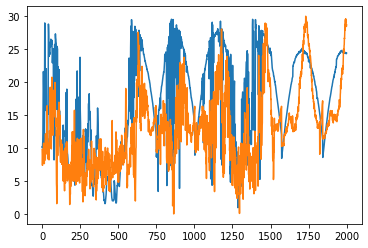

Got (62.04)


In [ ]:
test_x_2 = torch.Tensor(data_image[6000:8000])  # as torch.float32
test_y_2 = torch.Tensor(data_pred_pv[6000:8000])

my_dataset3 = TensorDataset(test_x_2, test_y_2) # create your datset
loader_test_2 = DataLoader(my_dataset3) # create your dataloader

def check_accuracy_part34(loader, model):
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    predictions = np.zeros(len(test_y_2),)
    i = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            scores = model(x)
            # print(scores)
            # _, preds = scores.max(1)
            # print(preds.numpy())
            predictions[i] = scores
            # print(predictions)
            # i += 1
            # num_correct += (preds == y).sum()
            # num_samples += preds.size(0)
            i += 1
        #warnings.filterwarnings('ignore')
        # UNCOMMENT SCALE LINE BELOW
        predictions = scale(predictions)
        #predictions = (1/(1 + np.exp(-predictions))) * 30
        # print(predictions)
        plt.plot(test_y_2)
        plt.plot(predictions)
        plt.show()

        mse = mean_squared_error(predictions, test_y_2)
        # mse = mean_squared_error(scale(predictions), test_y)
        # acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Got (%.2f)' % (mse))

check_accuracy_part34(loader_test_2, model)

**IGNORE BELOW JUST EXPERIMENTING**























SPACE


In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(data_image)  # as torch.float32
tensor_y = torch.Tensor(data_pv)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
dataloaders_dict = DataLoader(my_dataset) # create your dataloader

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))